In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

from wordcloud import WordCloud
import MeCab

In [3]:
# wikipediaの日本語版から作られたコーパス
# https://s3-ap-northeast-1.amazonaws.com/dev.tech-sketch.jp/chakki/public/ja.text8.zip
df = pd.read_csv('../input/amazon_reviews_multilingual_JP_v1_00.tsv', sep='\t')
print(df.shape)
df.head()

(262256, 15)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,JP,65317,R33RSUD4ZTRKT7,B000001GBJ,957145596,SONGS FROM A SECRET GARDE,Music,1,1,15,N,Y,残念ながら…,残念ながら…趣味ではありませんでした。ケルト音楽の範疇にも幅があるのですね…,2012-12-05
1,JP,65317,R2U1VB8GPZBBEH,B000YPWBQ2,904244932,鏡の中の鏡‾ペルト作品集(SACD)(Arvo Part:Spiegel im Spiegel),Music,1,4,20,N,Y,残念ながら…,残念ながら…趣味ではありませんでした。正直退屈…眠気も起きない…,2012-12-05
2,JP,65696,R1IBRCJPPGWVJW,B0002E5O9G,108978277,Les Miserables 10th Anniversary Concert,Music,5,2,3,N,Y,ドリームキャスト,素晴らしいパフォーマンス。ミュージカル映画版の物足りない歌唱とは違います。,2013-03-02
3,JP,67162,RL02CW5XLYONU,B00004SRJ5,606528497,It Takes a Nation of Millions to Hold Us Back,Music,5,6,9,N,Y,やっぱりマスト,専門的な事を言わずにお勧めレコメを書きたいのですが、文才が無いので無理でした。ヒップホップが...,2013-08-11
4,JP,67701,R2LA2SS3HU3A3L,B0093H8H8I,509738390,Intel CPU Core I3-3225 3.3GHz 3MBキャッシュ LGA1155...,PC,4,2,4,N,Y,コスパ的には十分,今までの環境（Core2 Duo E4600)に比べれば十分に快適になりました。<br />...,2013-02-10


# tokenizer作成
- 品詞を限定して、分かち書きした、単語のリストを返す

In [4]:
tagger = MeCab.Tagger("-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd")
def tokenize(text, target=['名詞', '動詞']):
        # 連結リスト
        node = tagger.parseToNode(text)

        result = []
        while node:
            hinshi = node.feature.split(",")[0]
            if hinshi in target:
                if node.feature.split(",")[6]!='*':
                    result.append(node.feature.split(",")[6])
                else:
                    result.append(node.surface)  # 原形で取得しようとする場合、英字だと表示されずに「*」となることがあるため、その場合はsurfaceを取る
            node = node.next

        return result

In [5]:
# 確認
text = '私は今日パンを食べました。'
print(tagger.parse(text))

私	ワタシ	私	名詞-代名詞-一般		
は	ハ	は	助詞-係助詞		
今日	キョウ	今日	名詞-副詞可能		
パン	パン	パン	名詞-一般		
を	ヲ	を	助詞-格助詞-一般		
食べ	タベ	食べる	動詞-自立	一段	連用形
まし	マシ	ます	助動詞	特殊・マス	連用形
た	タ	た	助動詞	特殊・タ	基本形
。	。	。	記号-句点		
EOS



In [6]:
tokenize(text)

['私', '今日', 'パン', '食べる']

## N-gram

In [7]:
tokens = tokenize(text)
tokens

['私', '今日', 'パン', '食べる']

In [8]:
# bi-gram
# 先頭から終端の1つ前までのリストと、先頭の次の語から終端までのリストを、zipでまとめて、リスト化する
list(zip(tokens[:-1], tokens[1:]))

[('私', '今日'), ('今日', 'パン'), ('パン', '食べる')]

In [9]:
# tri-gram
# 先頭から終端の2つ前までのリストと、先頭の次の語から終端の1つ手前までのリスト、
# それと、先頭の2つ先の語から終端までのリストを、zipでまとめて、リスト化する
list(zip(tokens[:-2], tokens[1:-1], tokens[2:]))

[('私', '今日', 'パン'), ('今日', 'パン', '食べる')]

### 上記を、N-gramに拡張する

zip(*list)：　リストを、転置して、tuple型に変換する

In [10]:
list(zip([tokens[i:] for i in range(3)]))

[(['私', '今日', 'パン', '食べる'],), (['今日', 'パン', '食べる'],), (['パン', '食べる'],)]

In [11]:
# *を取ることで、
list(zip(*[tokens[i:] for i in range(3)]))

[('私', '今日', 'パン'), ('今日', 'パン', '食べる')]

つまり、上記の２重リストは転置されて、短い列の分だけ表示される

ここで、N-gramsは、1つ後方にずらして、N個の組みを作るものなので、上記の方法で実現できる

In [12]:
def generate_ngram(tokens, n=1):
    return list(zip(*[tokens[i:] for i in range(n)]))

## 前処理

In [13]:
from bs4 import BeautifulSoup

def clean_html(text, strip=True):
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text(strip=strip)
    return text

In [14]:
import re
def nornalize_number(text):
    text = re.sub(r'\d+', '0', text)
    return text

In [15]:
with open('../input/stopwords_slothlib.txt', 'r') as f:
    stopwords = [w.strip() for w in f]
    stopwords = set(stopwords)

add_stopwords = {
    '*',
    'あ','い','う','え','お',
    'か','き','く','け','こ',
    'さ','し','す','せ','そ',
    'た','ち','つ','て','と',
    'な','に','ぬ','ね','の',
    'は','ひ','ふ','へ','ほ',
    'ま','み','む','め','も',
    'や','ゆ','よ',
    'わ' ,'を','ん',
    '0',
    'ã',
    'of',
    'the',
}
stopwords = stopwords | add_stopwords

def remove_stopwords(words):
    words = [w for w in words if w not in stopwords]
    return words

# Word count

In [16]:
%%time
word_list = [tokenize(nornalize_number(clean_html(text)), target=['名詞']) for text in df['review_body']]

/Users/fmasashi/.pyenv/versions/3.8.6/envs/text_japanese/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.amazon.co.jp/gp/product/B0040NOWY8/ref=cm_cr_ryp_prd_ttl_sol_3" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: user 5min 46s, sys: 23.4 s, total: 6min 9s
Wall time: 7min 12s


In [17]:
word_list_rm_stopwords = []
for wl in word_list:
    word_list_rm_stopwords.append([w for w in wl if w not in stopwords])

In [18]:
%%time
# n-gramに
word_list_ngram = [generate_ngram(tokens, n=2) for tokens in word_list_rm_stopwords]

CPU times: user 5 s, sys: 1.01 s, total: 6.01 s
Wall time: 7.12 s


In [19]:
word_list_ngram[0]

[('残念', '趣味'), ('趣味', 'ケルト音楽'), ('ケルト音楽', '範疇'), ('範疇', '幅')]

In [20]:
# 各行ごとのリストのリストでなく、1つのwordリストに
word_list_all = []
for w in word_list_ngram:
    word_list_all.extend(w)

In [21]:
from collections import Counter
cnt_word = Counter(word_list_all)
# cnt_word.most_common(n=10)

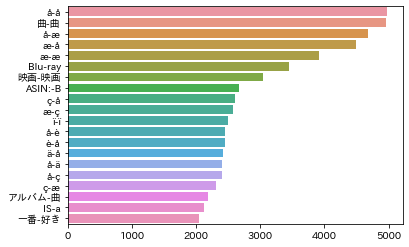

In [22]:
cnt_word_keys = []
cnt_word_values = []
for c in cnt_word.most_common(n=20):
    cnt_word_keys.append(c[0])
    cnt_word_values.append(c[1])

# plt.figure(figsize=(10, 20))
sns.barplot(x=cnt_word_values, y=['-'.join(w) for w in cnt_word_keys])
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=12)
plt.show()

In [23]:
# fpath = "/Library/Fonts/Arial Unicode.ttf"
# word_list_all_cat = ['&'.join(w) for w in word_list_all]
# words_wakati = ' '.join(word_list_all_cat)

# wordcloud = WordCloud(
#     font_path=fpath,
#     width=900, height=600,   # default width=400, height=200
#     background_color="white",   # default=”black”
# #     stopwords=set(stop_words),
#     max_words=500,   # default=200
#     min_font_size=4,   #default=4
#     collocations = False   #default = True
#     ).generate(words_wakati)
 
# plt.figure(figsize=(15,12))
# plt.imshow(wordcloud)
# plt.axis("off")
# # plt.savefig("word_cloud.png")
# plt.show()